# LangGraph로 만드는 고객지원 워크플로 큰 그림 설명

AI 고객지원 워크플로는 **큰 흐름(큰 그림) → 작은 단계** 순서로 이해하는 것이 가장 쉽습니다.  
아래는 전체 코드의 핵심 로직을 단계별로 정리한 설명입니다.

---

## 단계 1. 그래프적 사고로 워크플로 설계
- LangGraph는 복잡한 과정을 **그래프(노드+엣지)** 형태로 표현합니다.  
- 즉, "작업 단계(노드)"를 **점**, "단계 연결(엣지)"를 **선**으로 연결하여 **흐름도**처럼 만듭니다.

## 단계 2. 상태(State) 정의
- Workflow 진행 중 다뤄야 할 데이터(로그, 메모, 요약 등)를 **State**로 정의합니다.  
- 이 State가 노드를 지나가며 값이 추가되거나 수정됩니다.

## 단계 3. 노드(Node) 구성
- 각 노드는 "작업 함수"입니다. 예를 들어:  
  - **라우팅**: 티켓을 어디로 보낼지 결정  
  - **담당자 배정**: 누가 처리할지 기록  
  - **LLM 호출**: 요약이나 답변 생성

## 단계 4. 엣지(Edge)로 흐름 연결
- 노드와 노드를 순서대로 이어 **작업 경로**를 만듭니다.  
- `START → 라우팅 → 배정 → END` 와 같은 선형 흐름이 만들어집니다.

## 단계 5. LLM 활용
- 고객지원 내용을 **LLM이 요약**하거나 **자동 답변**을 생성합니다.  
- 티켓 개수 기반으로 우선순위를 계산하고, 그 길이에 맞춰 요약도 자동 생성합니다.

## 단계 6. 웹 검색/지식베이스 연결
- 고객 질문을 → 검색어로 바꾸고 → KB 문서 수집 후 → 답변 작성합니다.  
- 즉, "고객 질문"이 들어오면 → "검색" → "자료 정리" → "응답"의 흐름입니다.

---

💡 직관적 비유  
이 워크플로는 **콜센터 직원의 업무 흐름**을 자동화한 것과 같습니다.  
- 고객 질문을 받고(요청)  
- 관련 자료를 찾아보고(검색)  
- 정리해서 답변을 전달하는(응답) **흐름도**를 AI가 대신 수행하는 것입니다.


In [1]:
# ✅ 포인트: 실습 환경 준비 — 필요한 라이브러리를 업그레이드 설치합니다(Colab/Jupyter에서 즉시 실행 가능).
!pip3 install --upgrade langgraph langchain langchain_google_genai langchain_community

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 155 kB 3.5 MB/s eta 0:00:01
     |████████████████████████████████| 45 kB 6.7 MB/s eta 0:00:011
     |████████████████████████████████| 56 kB 6.9 MB/s eta 0:00:01
     |████████████████████████████████| 367 kB 7.5 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
# ✅ LangGraph 기초 예시 — 간단한 덧셈/뺄셈 워크플로
from typing import TypedDict
from langgraph.graph import StateGraph, START, END

# ✅ 1️⃣ State 정의 — 그래프 전체에서 공유되는 데이터
class CalcState(TypedDict):
    value: int  # 현재 숫자 상태


/Users/jinhohyeon/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:

# ✅ 2️⃣ Node 정의 — 각각의 계산 단계를 함수로 표현
def add_five(state: CalcState) -> CalcState:
    print("[1단계] 5 더하기")
    state["value"] += 5
    return state

def subtract_two(state: CalcState) -> CalcState:
    print("[2단계] 2 빼기")
    state["value"] -= 2
    return state

def show_result(state: CalcState) -> CalcState:
    print("[3단계] 결과 출력")
    print(f"🎯 최종 결과: {state['value']}")
    return state


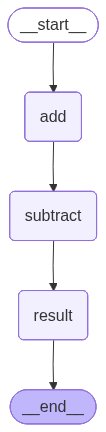

In [4]:
from langgraph.graph import StateGraph, START, END

# ✅ 3️⃣ 그래프 생성
builder = StateGraph(CalcState)

# 노드 등록
builder.add_node("add", add_five)
builder.add_node("subtract", subtract_two)
builder.add_node("result", show_result)

# ✅ 4️⃣ 실행 순서(Edge) 정의
builder.add_edge(START, "add")
builder.add_edge("add", "subtract")
builder.add_edge("subtract", "result")
builder.add_edge("result", END)

# ✅ 5️⃣ 그래프 컴파일 및 실행
app = builder.compile()
app


In [5]:

result = app.invoke({"value": 2})  # 초기값 0에서 시작

print("\n=== 계산 완료 ===")
print(f"최종 State: {result}")


[1단계] 5 더하기
[2단계] 2 빼기
[3단계] 결과 출력
🎯 최종 결과: 5

=== 계산 완료 ===
최종 State: {'value': 5}


In [7]:
# ✅ 포인트: 요청 제한자 — LLM 호출 빈도 제어(과금/한도 초과 방지용).
from langchain_core.rate_limiters import InMemoryRateLimiter
from langchain_google_genai import ChatGoogleGenerativeAI

# ✅ 포인트: 분당 10회 제한을 초당 단위로 환산(0.167 rps)해 스로틀링 구성.
throttle = InMemoryRateLimiter(
    requests_per_second=0.167,     # rps 설정(= 10 req/min)
    check_every_n_seconds=0.1,     # 주기적으로 토큰 버킷 체크
    max_bucket_size=10,            # 버킷 용량(버스트 허용치)
)

# ✅ 포인트: LLM 인스턴스 생성 — 위 스로틀러를 적용해 안전하게 호출합니다.
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash-exp",  # 경량·저지연 목적의 모델 선택(실습에 적합)
    rate_limiter=throttle          # 과도 호출 방지
)

# ✅ 포인트: 세 가지 필드를 가진 State — 입력(티켓 수)→계산(우선순위)→요약(LLM).
class TicketCalc(TypedDict):
    tickets_count: int      # 처리할 티켓 개수(입력)
    priority_tier: int      # 우선순위: sqrt 기반 정수(많을수록 상위 티어)
    briefing: str           # LLM이 생성한 간단 요약 결과

An error occurred: module 'importlib.metadata' has no attribute 'packages_distributions'


/Users/jinhohyeon/Library/Python/3.9/lib/python/site-packages/google/api_core/_python_version_support.py:252: FutureWarning: You are using a Python version (3.9.6) past its end of life. Google will update google.api_core with critical bug fixes on a best-effort basis, but not with any other fixes or features. Please upgrade to the latest Python version, or at least Python 3.10, and then update google.api_core.
  warnings.warn(message, FutureWarning)


In [8]:
# ✅ 포인트: 프롬프트/파서 — 체인 구성에 필요한 기본 컴포넌트입니다.
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

# ✅ 포인트: 우선순위 계산 — 티켓 수의 제곱근을 정수화(간단·직관적 중요도 지표).
def compute_tier(rec):
    return {"priority_tier": int(rec["tickets_count"] ** 0.5)}  # 예: 16개→sqrt=4→4

# ✅ 포인트: 요약 생성 — 우선순위(숫자)를 문장 수로 사용해 말머리표 요약을 생성합니다.
def draft_briefing(rec):
    prompt = ChatPromptTemplate([
        ('system', '고객지원 문서 요약을 명확히 작성하세요.'),  # 시스템 지시: 톤/역할 지정
        ('user', '{length} 문장으로 고객지원 워크플로를 말머리표 형태로 요약하세요.')  # 사용자 지시
    ])
    summary_chain = prompt | llm | StrOutputParser()  # 포인트: 프롬프트→LLM→문자열 파싱 체인
    return {"briefing": summary_chain.invoke({'length': rec['priority_tier']})}  # 길이=티어

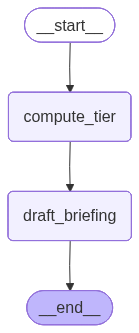

In [9]:
# ✅ 포인트: 그래프 구성 — 계산 후 요약을 수행하는 직선형 파이프라인.
flow = StateGraph(TicketCalc)
flow.add_node("compute_tier", compute_tier)       # 1단계: 우선순위 계산
flow.add_node("draft_briefing", draft_briefing)   # 2단계: LLM 요약

# ✅ 포인트: 실행 경로 — START→compute_tier→draft_briefing→END.
flow.add_edge(START, "compute_tier")
flow.add_edge("compute_tier", "draft_briefing")
flow.add_edge("draft_briefing", END)

# ✅ 포인트: 컴파일 — 실행 가능한 그래프 객체로 변환.
support_notes = flow.compile()
support_notes  # 구조 미리보기

In [10]:

# ✅ 포인트: 실행 — 티켓 16개를 입력으로 넣어 티어=4, 4문장 요약을 기대합니다.
seed = {'tickets_count': 16}  # 예시 입력(직관적 정수)
out = support_notes.invoke(seed)  # 그래프 실행
out  # 계산된 priority_tier와 briefing 확인

{'tickets_count': 16,
 'priority_tier': 4,
 'briefing': '다음은 고객지원 워크플로에 대한 4개의 말머리표로 요약된 내용입니다.\n\n*   고객이 이메일, 채팅 또는 전화를 통해 지원을 요청합니다.\n*   지원 요청이 분류되고 관련 지원 담당자에게 할당됩니다.\n*   지원 담당자는 고객 문제를 해결하고 고객에게 해결 방법을 제공합니다.\n*   고객 지원 담당자는 고객 만족도를 확인하기 위해 고객과 후속 조치를 취합니다.'}